### Visualización de filtros y detección de bordes

Los filtros lineales están basados en máscaras de convolución.

El borde de una imagen tiene dos atributos: dirección y amplitud. Los píxeles cambian suavemente a lo largo del borde y los píxeles cambian bruscamente perpendiculares al borde. Este cambio en el borde puede ser detectado por un operador diferencial, normalmente se utiliza una derivada de primer orden o de dos órdenes para detectar el borde.

Vamos a ver algunos filtros de detección de bordes:


La **derivada de una señal continua** nos da las variaciones locales con respecto a la variable, de forma que el valor de la derivada es mayor cuanto más rápidas son estas variaciones. 

En el caso bidimensional discreto, las distintas aproximaciones del operador gradiente se basan en diferencias entre los niveles de grises de la imagen. 
* La derivada parcial fx(x,y) puede aproximarse por la diferencia de píxeles adyacentes de la misma fila. 
* La derivada parcial fy(x,y) puede aproximarse por la diferencia de píxeles adyacentes de la misma columna. 

Existen muchos tipos de operadores (de derivada 1ra, derivada 2da, etc). Los mas comunes son:

* Operador de Sobel: obtenido a partir de derivada primera. Máscara de 3x3

<img src="images/sobel.png" alt="Drawing" style="width: 190px;"/>


* Operador de Prewitt: igual a Sobel. Se diferencia por los valores específicos de los elementos de matriz de la máscara de convolución.

<img src="images/prewitt.png" alt="Drawing" style="width: 190px;"/>

* Operador de Roberts: a diferencia de los anteriores puede detectar puntos de borde pero no la orientación de éstos. [[-1, 0], [0, 1]] y [[0, -1], [1, 0]]


Una **buena propiedad** de estos operadores es que es posible aumentar la dimensión de los filtros correspondientes sin alterar las propiedades de simetría y operación de dicho filtro (máscara).


Hay otros método de detección de bordes como el algoritmo de Canny

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


img_path = 'images/taxi_r12.jpeg'


bgr_img = cv2.imread(img_path)
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)



In [2]:
gray_img.max()

255

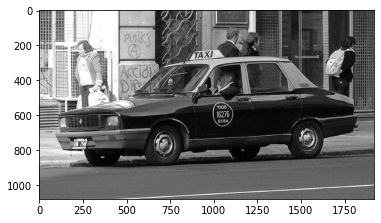

In [3]:
# normalizar al intervalo [0,1]
gray_img = gray_img.astype("float32") / 255

plt.imshow(gray_img, cmap='gray')
plt.show()

In [4]:
import numpy as np

# definicion de un filtro generico para deteccion de bordes
filtro_gen = np.array(
    [[-1, -1, 1, 1], 
     [-1, -1, 1, 1], 
     [-1, -1, 1, 1], 
     [-1, -1, 1, 1]]
)

filtro_gen.shape

(4, 4)

In [5]:
# definimos 4 filtros
filtro_1 = filtro_gen
filtro_2 = -filtro_1
filtro_3 = filtro_1.T
filtro_4 = -filtro_3
filtros = np.array([filtro_1, filtro_2, filtro_3, filtro_4])

print('Filtros: \n', filtros)

Filtros: 
 [[[-1 -1  1  1]
  [-1 -1  1  1]
  [-1 -1  1  1]
  [-1 -1  1  1]]

 [[ 1  1 -1 -1]
  [ 1  1 -1 -1]
  [ 1  1 -1 -1]
  [ 1  1 -1 -1]]

 [[-1 -1 -1 -1]
  [-1 -1 -1 -1]
  [ 1  1  1  1]
  [ 1  1  1  1]]

 [[ 1  1  1  1]
  [ 1  1  1  1]
  [-1 -1 -1 -1]
  [-1 -1 -1 -1]]]


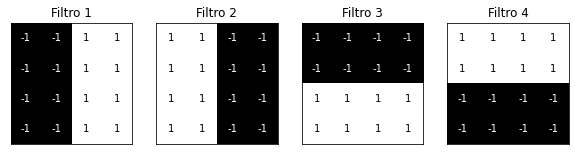

In [6]:
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filtros[i], cmap='gray')
    ax.set_title('Filtro %s' % str(i+1))
    w, h = filtros[i].shape
    for x in range(w):
        for y in range(h):
            ax.annotate(str(filtros[i][x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if filtros[i][x][y]<0 else 'black')

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    

class Net(nn.Module):
    
    def __init__(self, weight):
        super(Net, self).__init__()
        # inicializacion de los pesos de la capa convolucional con los persos de los 4 filtros definidos
        k_height, k_width = weight.shape[2:]
        
        # 4 filtros de entrada para imagen en blanco y negro
        self.conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
        self.conv.weight = torch.nn.Parameter(weight)

    def forward(self, x):
        # output resultante de la capa de convolucion
        conv_x = self.conv(x)
        
        # output aplucando funcion de activacion
        activated_x = F.relu(conv_x)
        
        return conv_x, activated_x
    
# inicializar modelos con los pesos de los filtros que definimos
pesos = torch.from_numpy(filtros).unsqueeze(1).type(torch.FloatTensor)
model = Net(pesos)

print(model)

Net(
  (conv): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [8]:
model.conv.weight

Parameter containing:
tensor([[[[-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.]]],


        [[[ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.]]],


        [[[-1., -1., -1., -1.],
          [-1., -1., -1., -1.],
          [ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.]]],


        [[[ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.],
          [-1., -1., -1., -1.],
          [-1., -1., -1., -1.]]]], requires_grad=True)

In [9]:
def viz_layer(layer, n_filtros= 4):
    fig = plt.figure(figsize=(25, 25))
    
    for i in range(n_filtros):
        ax = fig.add_subplot(1, n_filtros, i+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(layer[0, i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

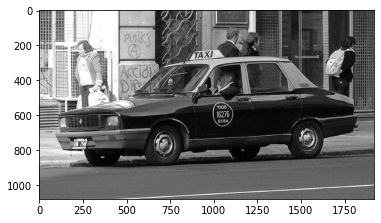

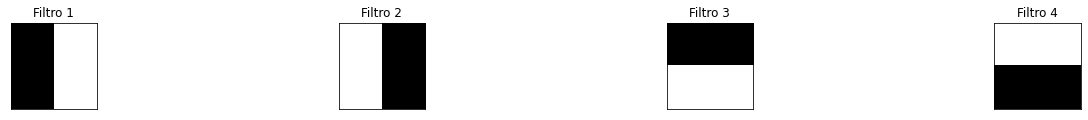

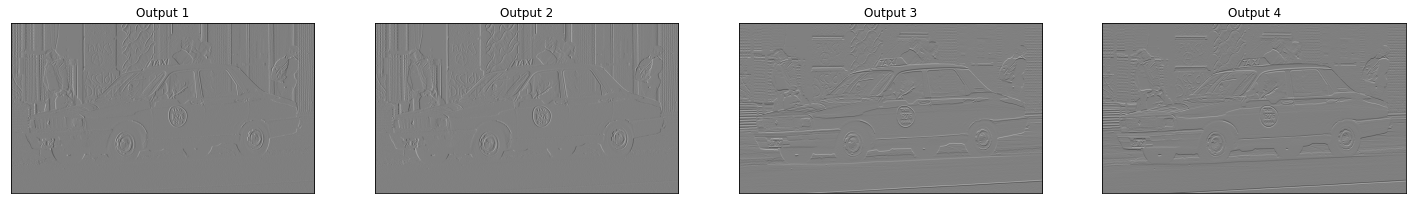

In [10]:
plt.imshow(gray_img, cmap='gray')

# visualizacion de los filtros resultates
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filtros[i], cmap='gray')
    ax.set_title('Filtro %s' % str(i+1))

    
# imagen de entrada a tensor para meter al modelo
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# imagen en modelo
conv_layer, activated_layer = model(gray_img_tensor)

# visualizacion de la salida de la capa de convolucion
viz_layer(conv_layer)


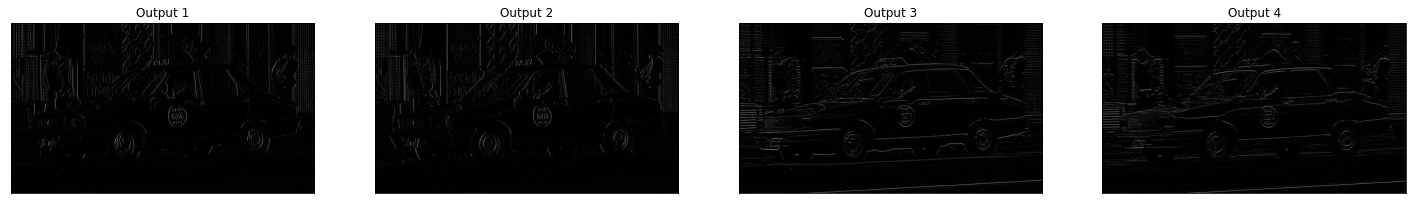

In [99]:
# visualizacion de la capa de convlucion con funcion de activacion
viz_layer(activated_layer)

# Otras visualizaciones:

https://arxiv.org/pdf/1311.2901.pdf

https://thegradient.pub/a-visual-history-of-interpretation-for-image-recognition/

<img src="images/filtros_vis_2.png" alt="Drawing" style="width: 390px;"/>